In [1]:
# run in base
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpytorch

from utils import make_grid
from configs import N_SIDE_INFERENCE

from scipy.interpolate import griddata
from real_preprocess import load_and_preprocess_ice_velocity_data

# Translate prediction sample back

Sample 1 for region_lower_byrd ice thickness:


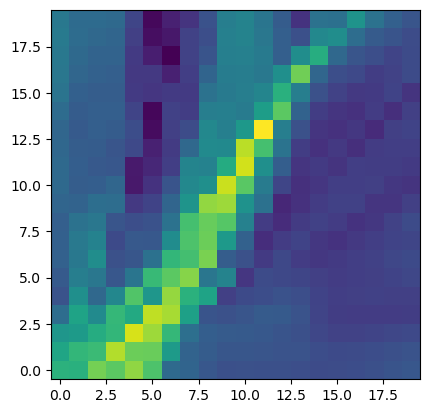

Sample 2 for region_lower_byrd ice thickness:


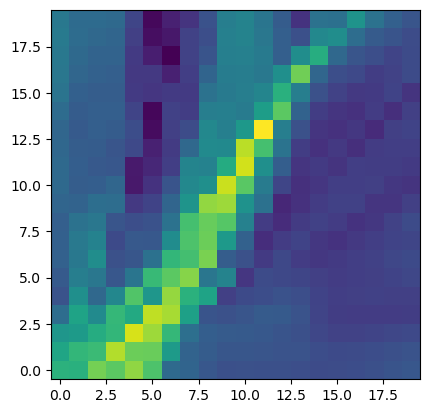

Sample 1 for region_mid_byrd ice thickness:


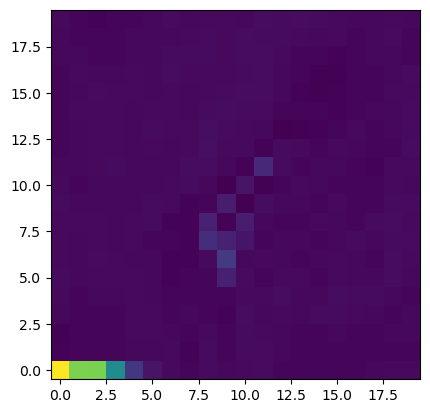

Sample 2 for region_mid_byrd ice thickness:


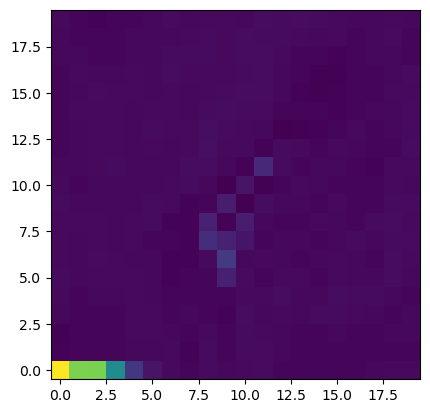

Sample 1 for region_upper_byrd ice thickness:


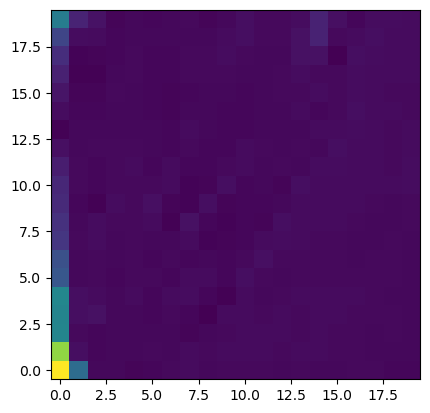

Sample 2 for region_upper_byrd ice thickness:


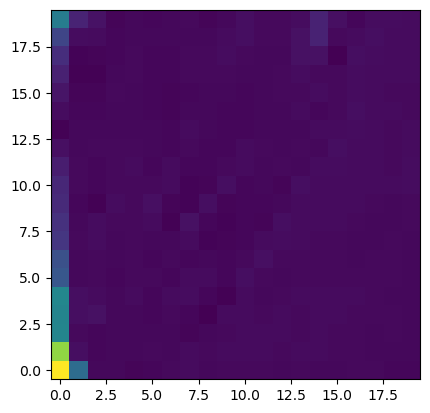

In [6]:
N_SAMPLES = 2
folder_path = "results_real/dfNGP_grid_inference/"
export_path = "results_real/dfNGP_grid_inference/samples/"

# LOOP OVER REGIONS
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:
# for region in ["region_lower_byrd"]:

    # STEP 1: load data
    mean_file_path = folder_path + region + "_dfNGP_grid_mean_predictions.pt"
    covar_file_path = folder_path + region + "_dfNGP_grid_covar_predictions.pt"
    # latent_covar_file_path = folder_path + region + "_dfNGP_grid_latent_covar_predictions.pt"

    mean = torch.load(mean_file_path, weights_only = False)
    covar = torch.load(covar_file_path, weights_only = False)
    # latent_covar = torch.load(latent_covar_file_path, weights_only = False)

    N_SIDE_INFERENCE = int(np.sqrt(mean.shape[0]))

    # STEP 2: Put back into MultitaskMultivariateNormal format
    posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)
    # posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean, latent_covar)

    # STEP 3: Prep region scaling specs
    region_specs = pd.read_csv("data/real_data/corners_byrd_regions.csv")
    flux_scalar = region_specs.loc[region_specs["name"] == region, "flux_scalar"].values[0]

    # STEP 4: Scale x_grid back to polar stereographic coordinates
    _, x_grid = make_grid(N_SIDE_INFERENCE)

    x_min = region_specs.loc[region_specs["name"] == region, "x_min"].values[0]
    x_max = region_specs.loc[region_specs["name"] == region, "x_max"].values[0]

    x1_ps = x_grid[:, 0] * (x_max - x_min) + x_min

    y_min = region_specs.loc[region_specs["name"] == region, "y_min"].values[0]
    y_max = region_specs.loc[region_specs["name"] == region, "y_max"].values[0]

    x2_ps = x_grid[:, 1] * (y_max - y_min) + y_min

    x_grid_ps = torch.cat((x1_ps.unsqueeze(1), x2_ps.unsqueeze(1)), dim = 1)
    x_grid_ps_df = pd.DataFrame(x_grid_ps.numpy(), columns = ["x", "y"])

    # Step 5: Interpolate ice velocity 

    ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
    # Function to load and preprocess the ice velocity data as xarray

    velocity_grid = load_and_preprocess_ice_velocity_data(ice_vel_file_path)
    # Subset vars for faster interpolation
    velocity_grid = velocity_grid[["VX", "VY"]]

    velocity_grid_interpolated = velocity_grid.interp(
            y = (x_grid_ps_df["y"]), 
            x = (x_grid_ps_df["x"]), 
            method = "cubic") # smooth interpolation

    # Interpolates for combinations of points so we only need diagonal
    VX_diag = np.diag(velocity_grid_interpolated.VX.values)
    VY_diag = np.diag(velocity_grid_interpolated.VY.values)

    # Step 6: Calculate velocity magnitude
    velocity_magnitude = np.sqrt(VX_diag**2 + VY_diag**2)
    
    # STEP 7: Sample from posterior, scale, calculate ic thickness, export
    for i in range(N_SAMPLES):
        # Sample
        # sample = posterior.rsample()
        sample = posterior.mean
        # Scale
        sample_scaled = sample * flux_scalar
        # Magnitude
        sample_magnitude = torch.sqrt(sample_scaled[:, 0]**2 + sample_scaled[:, 1]**2)
        # Ice thickness t = |flux| / |v|
        sample_thickness = sample_magnitude.detach().cpu().numpy() / velocity_magnitude
        # Reshape
        sample_thickness_field = sample_thickness.reshape((N_SIDE_INFERENCE, N_SIDE_INFERENCE))
        # Export
        torch.save(torch.tensor(sample_thickness_field), export_path + region + "_dfNGP_sample_" + str(i) + "_thickness.pt")
        
        # STEP 8: Visualise
        print(f"Sample {i + 1} for {region} ice thickness:")
        plt.imshow(sample_thickness_field, cmap = 'viridis', origin = 'lower')
        plt.show()

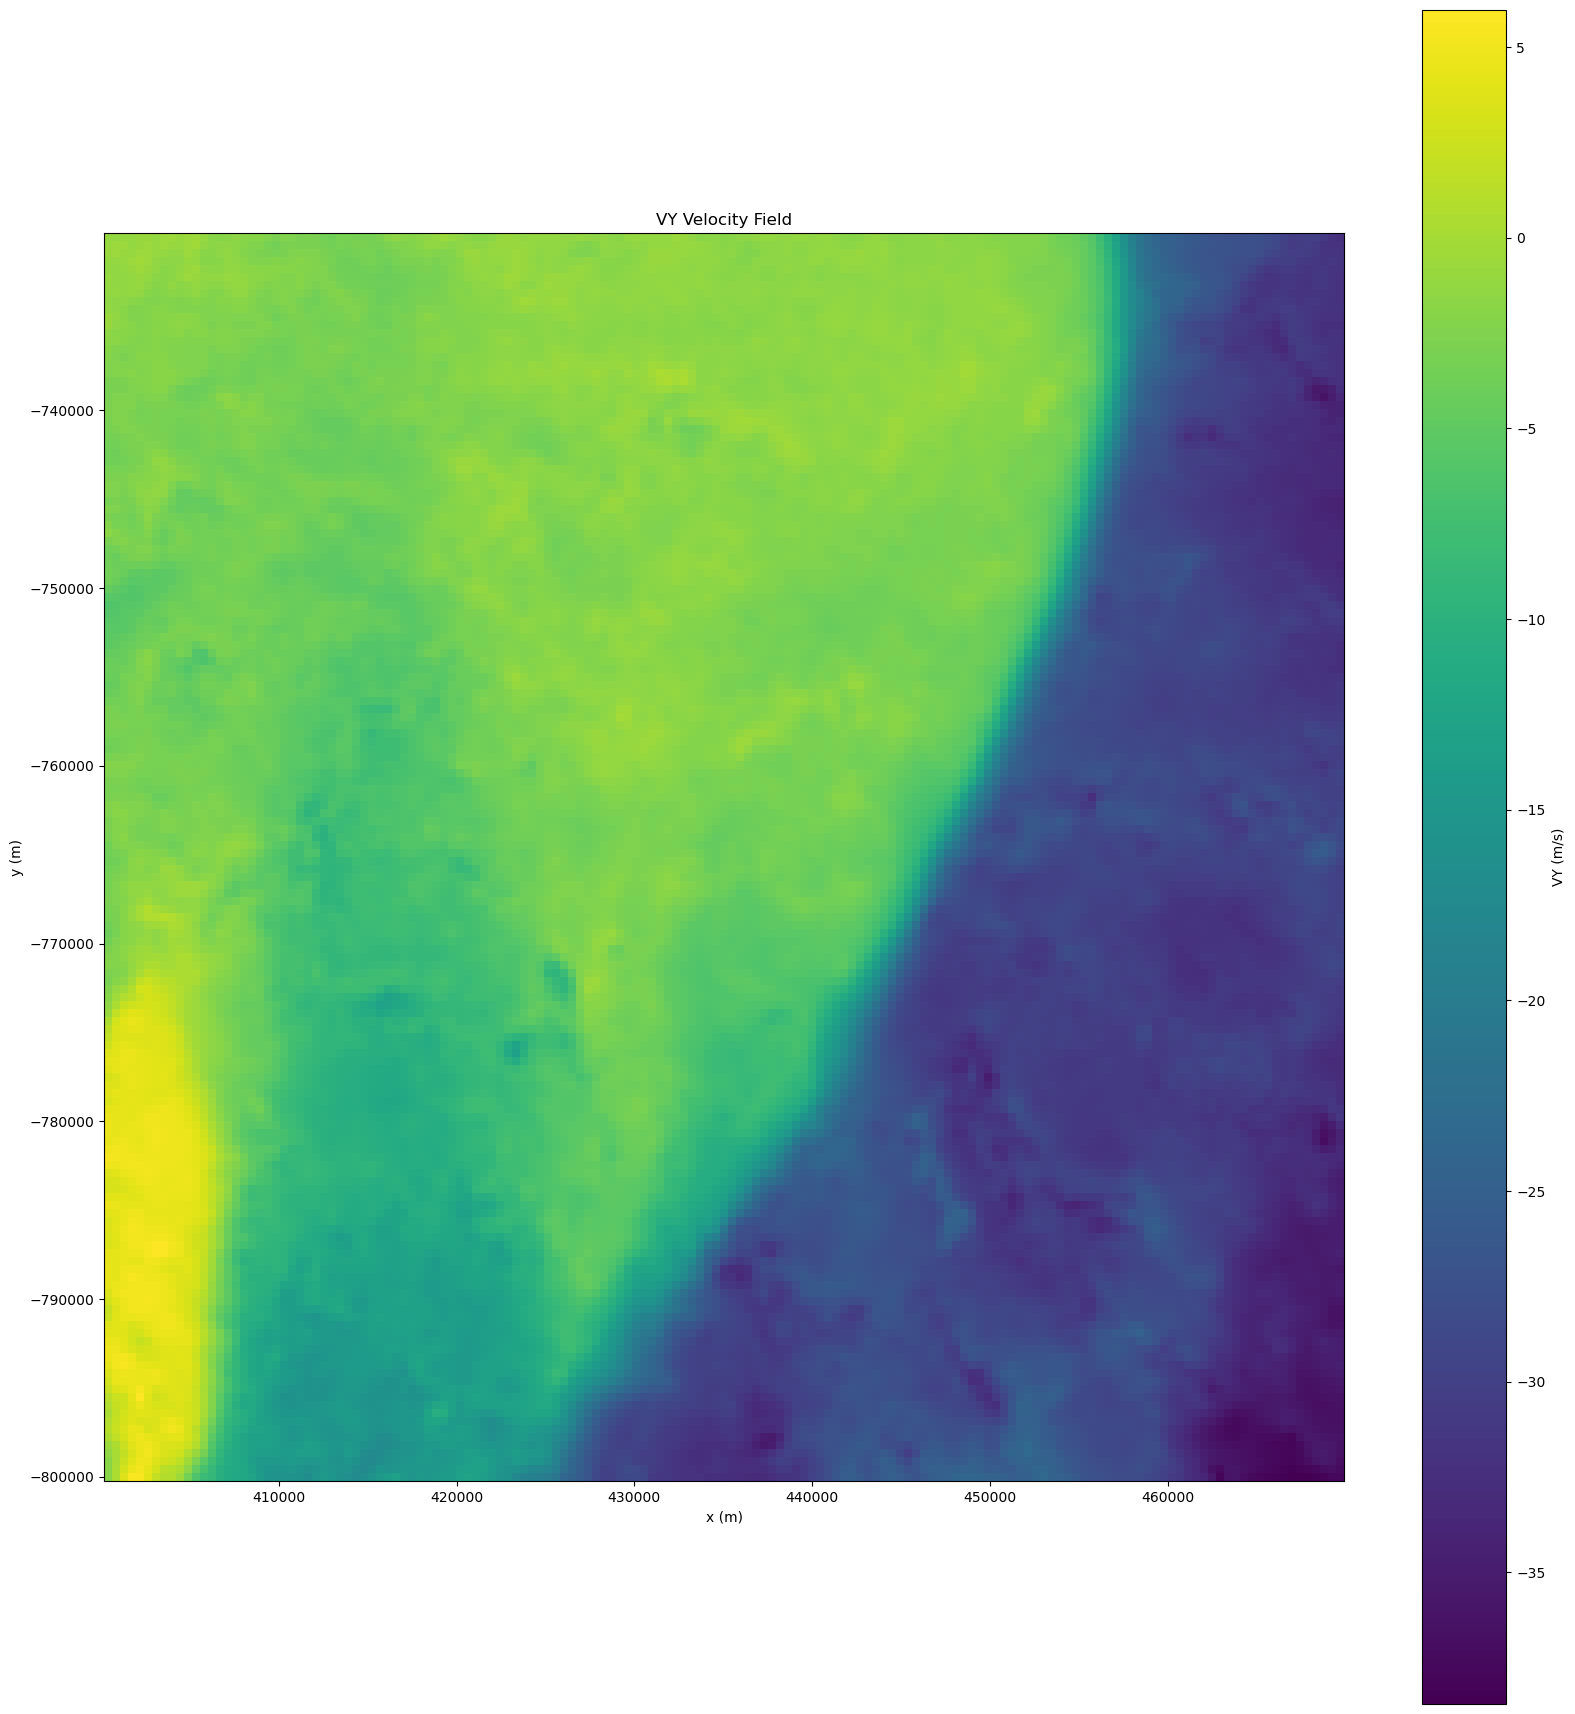

In [7]:
subset = velocity_grid.sel(
    x = slice(400_000, 470_000),
    y = slice(-730_000, -800_000)  # y often decreases from top to bottom
)

plt.figure(figsize=(20, 22))
plt.pcolormesh(
    subset.x.values,
    subset.y.values,
    subset.VY.values,
    cmap='viridis',
    shading='auto'
)
plt.colorbar(label='VY (m/s)')
plt.title("VY Velocity Field")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.gca().set_aspect('equal')

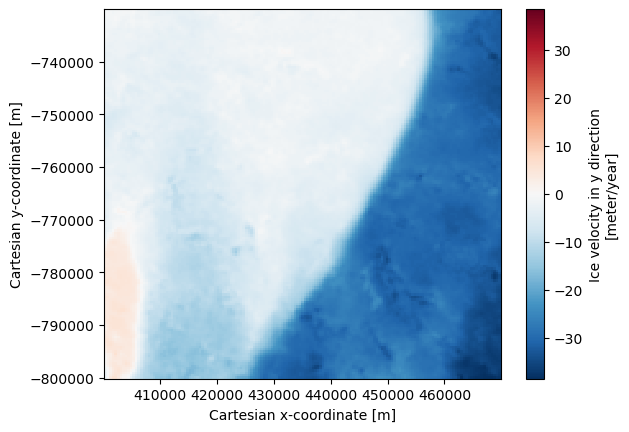

In [8]:
subset.VY.plot()

In [ ]:
plt.imshow(subset.VY.values)

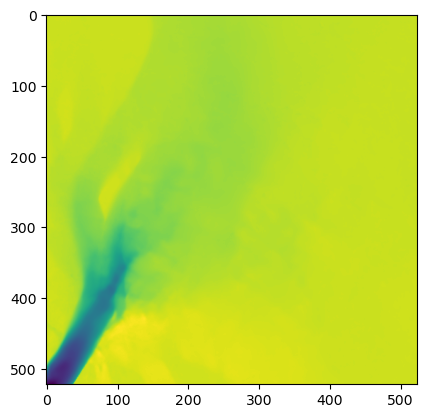

In [51]:
plt.imshow(velocity_grid.VY.values)

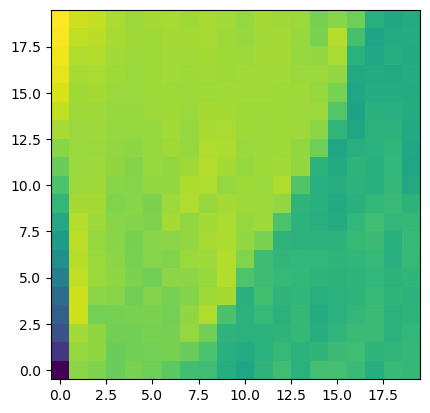

In [10]:
# sample_scaled[:, 0].reshape(30, 30)
plt.imshow(sample_scaled[:, 1].reshape(N_SIDE_INFERENCE, N_SIDE_INFERENCE).detach().cpu(), origin = 'lower')

In [11]:
sample_scaled[:, 0].cpu() / torch.tensor(VX_diag)

tensor([-7.9929e+04, -2.2566e+04, -1.5642e+03, -1.2556e+03, -9.6076e+02,
         1.2822e+01,  1.3418e+03,  1.9522e+03,  1.5527e+03,  1.5394e+03,
         1.3932e+03,  1.3086e+03,  1.0536e+03,  1.1706e+03,  1.4036e+03,
         1.4362e+03,  1.5586e+03,  1.5929e+03,  1.3860e+03,  1.0676e+03,
        -7.7697e+02,  2.8033e+03,  1.7250e+03,  1.3449e+03,  1.7046e+03,
         1.5203e+03,  1.5143e+03,  1.9283e+03,  1.9177e+03,  1.7976e+03,
         1.8758e+03,  1.8970e+03,  1.7420e+03,  1.9851e+03,  1.9698e+03,
         1.6702e+03,  1.6048e+03,  1.6199e+03,  1.6454e+03,  1.4240e+03,
        -2.8635e+03,  3.2048e+03,  1.0472e+03,  1.0328e+03,  1.4505e+03,
         1.5060e+03,  1.6384e+03,  1.0234e+03,  1.4154e+03,  1.7824e+03,
         1.8047e+03,  1.8577e+03,  1.7655e+03,  1.8062e+03,  1.8202e+03,
         1.7070e+03,  1.5381e+03,  1.3973e+03,  1.4171e+03,  1.4202e+03,
        -4.4035e+03, -1.3900e+03,  1.7710e+03,  1.6236e+03,  1.3609e+03,
         1.9336e+03,  1.8726e+03,  7.5232e+02,  3.3

In [12]:
np.set_printoptions(precision=4, suppress=True)
VY_diag

print(region)
plt.imshow(VY_diag.reshape(30, 30), origin = 'lower')

region_upper_byrd


ValueError: cannot reshape array of size 400 into shape (30,30)

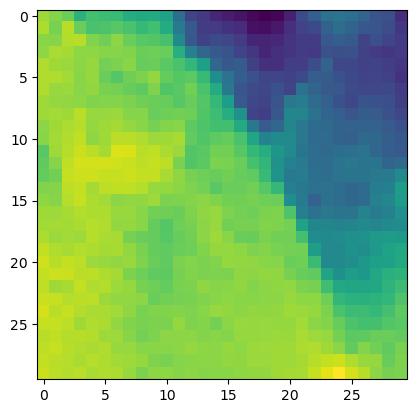

In [45]:
plt.imshow(VX_diag.reshape(30, 30))

In [36]:
VY_diag

array([ -3.9297,   4.953 ,  -2.9814, -11.6171, -15.5726, -15.3651,
       -17.2018, -13.9347, -13.9863, -14.0417, -19.1969, -24.7259,
       -29.4286, -31.4414, -32.1734, -32.9534, -31.5322, -27.5533,
       -26.7252, -27.0672, -24.0743, -24.8345, -23.6857, -27.2269,
       -28.3217, -30.8865, -37.3027, -37.6252, -38.3499, -38.0836,
        -0.5441,   4.3097,   3.3532, -10.0495, -13.3003, -14.4345,
       -14.7264, -14.9753, -14.0432, -16.2865, -14.5727, -20.2087,
       -29.6246, -30.3411, -31.8987, -32.2069, -31.0578, -27.2075,
       -26.5588, -27.3402, -27.9604, -26.4666, -25.7907, -28.2968,
       -28.8229, -31.985 , -36.666 , -37.005 , -35.7471, -36.354 ,
         0.619 ,   5.1738,   3.5981,  -7.568 , -13.9478, -15.7655,
       -14.6514, -15.2773, -13.4534, -13.1027, -12.4098, -14.5361,
       -22.7302, -26.6371, -30.2269, -31.1375, -30.0504, -28.4301,
       -27.511 , -28.6909, -28.5123, -29.0351, -25.6643, -28.869 ,
       -27.7275, -31.1374, -34.6847, -35.1841, -36.5116, -35.7